# Applying SVM to GR Crash Data

* Instead of their traditional SVM, I could use the [Stochastic Gradient Descent Classifier](http://scikit-learn.org/stable/modules/sgd.html)

```python
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", alpha=0.01, penalty="l2", fit_intercept=True)
clf.fit(X, y)
```

Note that `SVC(kernel="linear")` is equivalent to `SGDClassifier(loss="hinge")` as [scikit-learn's documentation indicates](http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-unbalanced-py)

* For our purposes, the [LinearSVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) is our most scalable option.

In [4]:
X_cols = ['X', 'Y', 'DRIVER1AGE', 'NUMOFINJ', 'HOUR_X', 'HOUR_Y',
          'CRASHSEVER_Fatal', 'CRASHSEVER_Injury', 'DRIVER1SEX_M', 'DRIVER1SEX_U',
          'HITANDRUN_Yes', 'MOTORCYCLE_Yes',
          'D1COND_Appeared Normal', 'D1COND_Fatigue / Sick']
y_cols = 'D1DRINKIN_Yes'

In [5]:
crash_data = pd.read_csv('Data/Crash_data_prepared.csv')
#data_url = "https://raw.githubusercontent.com/collinprather/Big-Data-Ignite-2018/master/Data/Crash_data_prepared.csv"
#crash_data = pd.read_csv(data_url)
X = crash_data.loc[:, X_cols]
y = crash_data.loc[:, y_cols]

In [6]:
crash_data.head()

,X,Y,DRIVER1AGE,NUMOFINJ,HOUR_X,HOUR_Y,CRASHSEVER_Fatal,CRASHSEVER_Injury,DRIVER1SEX_M,DRIVER1SEX_U,EMRGVEH_Yes,HITANDRUN_Yes,MOTORCYCLE_Yes,D1COND_Appeared Normal,D1COND_Fatigue / Sick,D1DRINKIN_Yes,SPEEDLIMIT_BINS_25<speed<45,SPEEDLIMIT_BINS_45<speed<65,SPEEDLIMIT_BINS_65<speed
0,0.406318,-0.996140,1.685157,-0.416816,-0.258819,-9.659258e-01,0,0,0,0,0,1,0,1,0,0,1,0,0
1,0.411006,-0.996237,-0.269018,-0.416816,-1.000000,-1.836970e-16,0,0,1,0,0,1,0,0,0,0,1,0,0
2,0.413936,-0.996298,-0.836360,-0.416816,0.866025,-5.000000e-01,0,0,0,0,0,0,0,1,0,0,1,0,0
3,0.416866,-0.996358,-0.332056,-0.416816,-0.866025,-5.000000e-01,0,0,1,0,0,1,0,1,0,0,1,0,0
4,0.416866,-0.996358,0.550474,-0.416816,-0.707107,-7.071068e-01,0,0,1,0,0,0,0,1,0,0,1,0,0


## Statistical Re-sampling
Since the recall was still very low after training our SVM, we will use a statistical re-sampling technique designed for dealing with imbalanced classes, like ours. We'll be using some tools from the [imbalanced-learn package](http://contrib.scikit-learn.org/imbalanced-learn/stable/under_sampling.html)

* `Recall` is our metric of choice. [this article](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c) provides a great explanation for why
    * In our instance, we're okay with incorectly guessing that there was alcohol involved with some car crashes, if it means predicting all the instances when there was alcohol involved
    * Generally speaking, when dealing with an imbalanced dataset, oversampling is a good technique to increase recall
* [this](https://beckernick.github.io/oversampling-modeling/) is a great article on the right way to oversample.

In [19]:
#!pip install -U imbalanced-learn        # only run this in colab.research.google.com
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC, SVC
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=742)

In [9]:
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train)

In [10]:
print("From the training data, the number of observations from each class is as follows:", sorted(Counter(y_train).items()), "\n")
print("From the oversampled training data, the number of observations from each class is as follows:", sorted(Counter(y_train_resampled).items()), "\n")

From the training data, the number of observations from each class is as follows: [(0, 52717), (1, 2015)] 

From the oversampled training data, the number of observations from each class is as follows: [(0, 52717), (1, 52717)] 



In [26]:
#clf = LinearSVC(penalty='l2', loss='hinge')
clf = SVC(kernel = 'linear')
clf.fit(X_train_resampled, y_train_resampled)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.91      0.95     17543
          1       0.30      0.94      0.46       702

avg / total       0.97      0.91      0.93     18245



In [28]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('True negatives:', tn)
print('True positives:', tp)
print('False negatives:', fn)
print('False Positives:', fp)
print('\n', confusion_matrix(y_test, y_pred))

True negatives: 16032
True positives: 657
False negatives: 45
False Positives: 1511

 [[16032  1511]
 [   45   657]]


In [29]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.91  0.09]
 [ 0.06  0.94]]


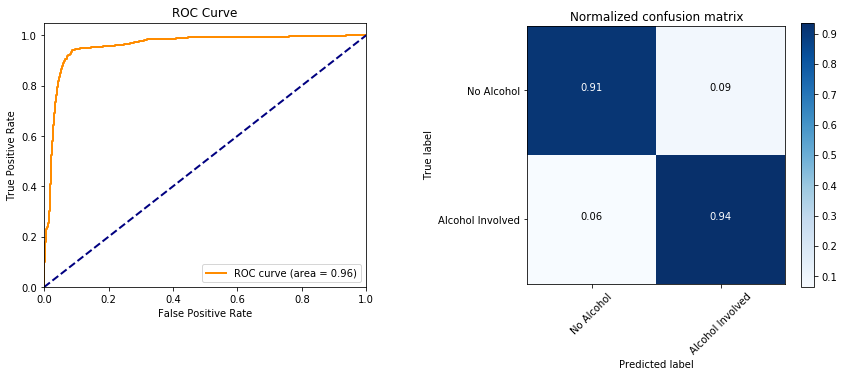

In [30]:
# define figure and add subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

y_score = clf.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
lw=2
ax1.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend(loc="lower right")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(cm, classes=['No Alcohol', 'Alcohol Involved'], normalize=True,
                      title='Normalized confusion matrix')

# adjust spacing
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=.5, hspace=None)

Here are [some good explanations](https://stats.stackexchange.com/questions/37795/roc-curve-for-discrete-classifiers-like-svm-why-do-we-still-call-it-a-curve) for how to form an ROC Curve for a SVM. It's necessary to introduce our own threshold values in order to obtain probabilities required.